## Assignment 3

## ZhengYang Li 24024484

### **Linear Model Experimentation**

#### **Introduction**

To contrast with the previous experiments involving complex tree-based models such as CatBoost and XGBoost, this project also specifically conducted a series of experiments with linear models. The core objective of this part of the work is:
1. Build and evaluate the performance of a linear regression model in predicting the New Zealand House Price Index (HPI).
2.  By analyzing the coefficients of the model, one can intuitively understand the **linear impact** of various macroeconomic characteristics on house prices.
3.  Compare the performance of models under different feature combinations, and finally compare the overall performance of the linear model with that of the tree-based model to explore the advantages and disadvantages of different model architectures in this prediction task.

This analysis also utilized the `clean_house.csv` dataset that the team had previously prepared.

#### **2.Analysis**

**2.1 Data Preparation**
* **Data loading and filtering**: Firstly, the `clean_house.csv` data was loaded, and the data after March 31, 2000 was selected to ensure the completeness of all features (especially OCR).
* **Target variable normalization**: To facilitate model training and result interpretation, the target variable `hpi` (house price index) was **normalized** (Min-Max Scaling) to the range of 0 to 1, resulting in `hpi_norm`. The model will directly predict this normalized house price index.
* **Data set division**：Consistent with the previous experiments, the data was strictly divided into the training set and the test set according to the chronological order.

**2.2 Model Development & Evaluation**
In the experiment, three linear regression models with increasing complexity were constructed, and the **R² score (coefficient of determination)** was used to evaluate them on the test set. The higher the R² score, the stronger the model's ability to explain the data.

* **Model 1: Core Economic Indicator Model**
    * **feature**: `ocr`, `cpi`, `gdp`
    * **result**: This model achieved an R² score of **0.8441**, demonstrating a stable performance.

* **Model 2: Incorporating Market Behavior Indicators Model**
    * **feature**: `ocr`, `cpi`, `gdp`, `house_sales`, `house_stock`, `residential_investment`
    * **result**: After adding more features, the performance of the model actually declined.，**The R² score is 0.7953**.

* **Model 3：Full Feature Model**
    * **feature**: All available features in the dataset were utilized (including the lagged and rolling items that we previously created).
    * **result**: The performance of the model using all features has improved somewhat, but it still has not surpassed the performance of the simplest model 1.，the**R² score is 0.8349**.

**Analysis and Interpretation**
The results show that Model 1 (which only includes core economic indicators) performed the best. However, Model 2 and Model 3, which included more features, performed worse instead. This is likely due to **multicollinearity** or **overfitting**. In linear models, adding too many related or unnecessary features sometimes interferes with the model and reduces its generalization ability on new data.

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Visualization

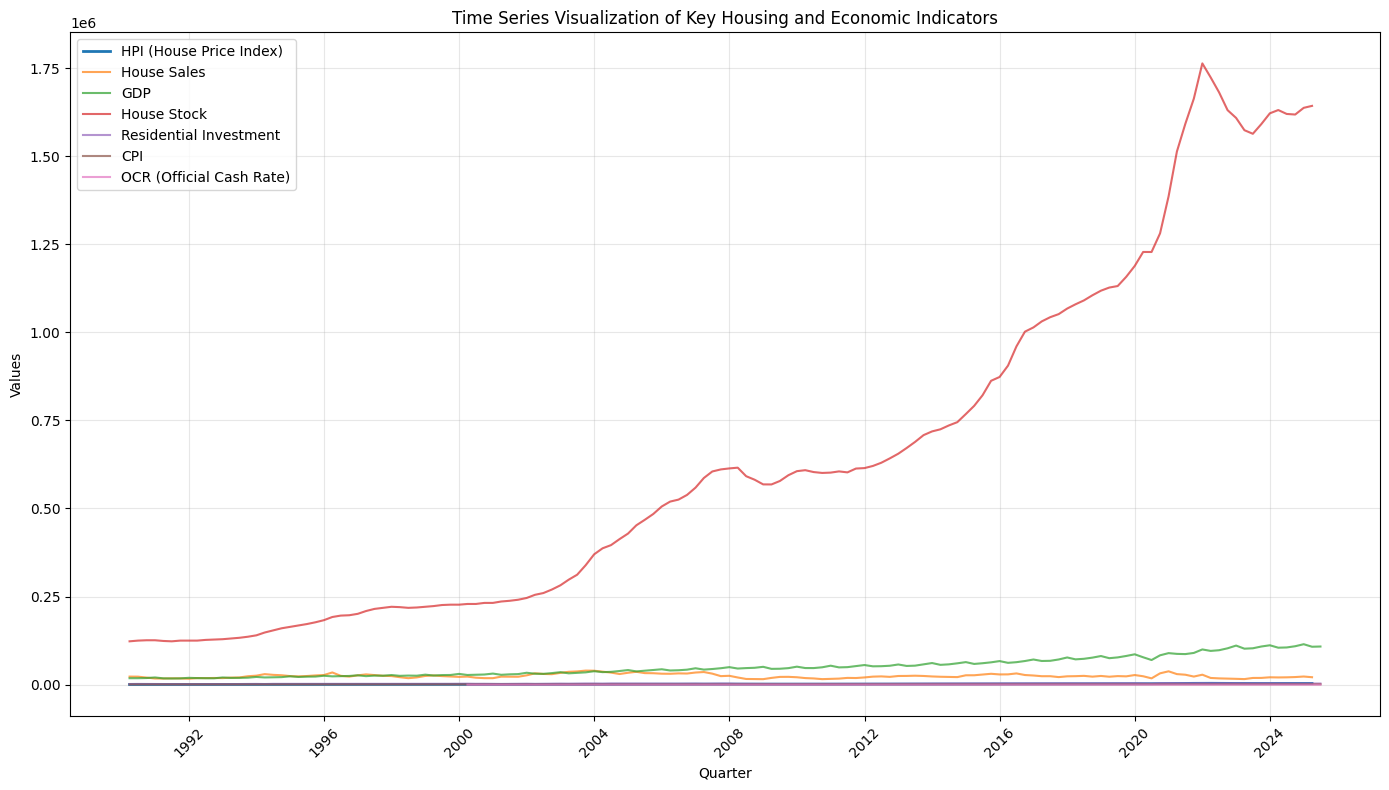

In [2]:
df = pd.read_csv("./clean_house.csv")
df['quarter'] = pd.to_datetime(df['quarter'])
df.set_index('quarter', inplace=True)

plt.figure(figsize=(14, 8))
plt.plot(df.index, df['hpi'], label='HPI (House Price Index)', linewidth=2)
plt.plot(df.index, df['house_sales'], label='House Sales', alpha=0.7)
plt.plot(df.index, df['gdp'], label='GDP', alpha=0.7)
plt.plot(df.index, df['house_stock'], label='House Stock', alpha=0.7)
plt.plot(df.index, df['residential_investment'], label='Residential Investment', alpha=0.7)
plt.plot(df.index, df['cpi'], label='CPI', alpha=0.7)
plt.plot(df.index, df['ocr'].fillna(method='ffill'), label='OCR (Official Cash Rate)', alpha=0.7)
plt.title('Time Series Visualization of Key Housing and Economic Indicators')
plt.xlabel('Quarter')
plt.ylabel('Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Normalization

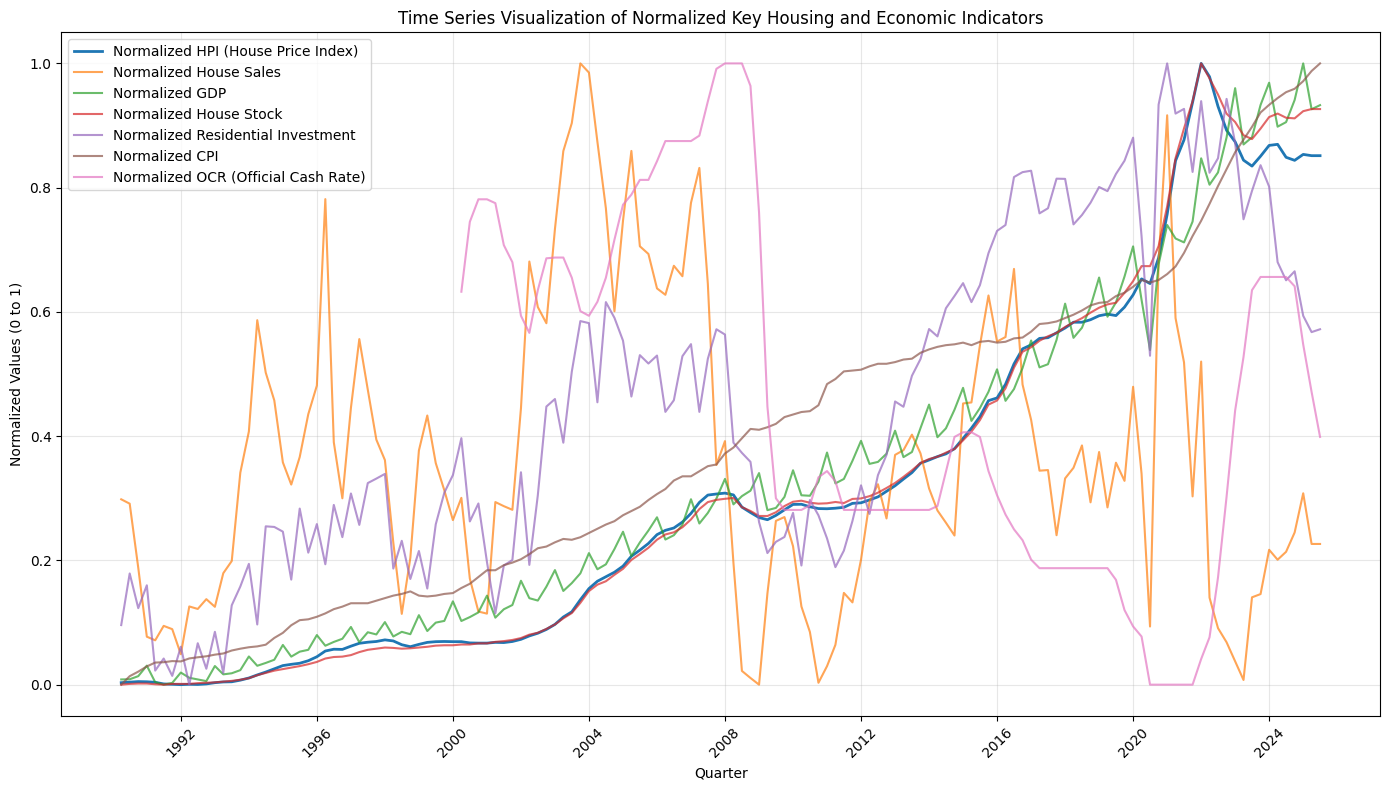

In [3]:
df = pd.read_csv("./clean_house.csv")
df['quarter'] = pd.to_datetime(df['quarter'])
df.set_index('quarter', inplace=True)
features = ['hpi', 'house_sales', 'gdp', 'house_stock', 'residential_investment', 'ocr','cpi']
df_subset = df[features].fillna(method='ffill')
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_subset), 
                             columns=features, 
                             index=df_subset.index)

# Visualize normalized values on the same plot
plt.figure(figsize=(14, 8))
plt.plot(df_normalized.index, df_normalized['hpi'], label='Normalized HPI (House Price Index)', linewidth=2)
plt.plot(df_normalized.index, df_normalized['house_sales'], label='Normalized House Sales', alpha=0.7)
plt.plot(df_normalized.index, df_normalized['gdp'], label='Normalized GDP', alpha=0.7)
plt.plot(df_normalized.index, df_normalized['house_stock'], label='Normalized House Stock', alpha=0.7)
plt.plot(df_normalized.index, df_normalized['residential_investment'], label='Normalized Residential Investment', alpha=0.7)
plt.plot(df_normalized.index, df_normalized['cpi'], label='Normalized CPI', alpha=0.7)
plt.plot(df_normalized.index, df_normalized['ocr'], label='Normalized OCR (Official Cash Rate)', alpha=0.7)
plt.title('Time Series Visualization of Normalized Key Housing and Economic Indicators')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values (0 to 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation Analysis

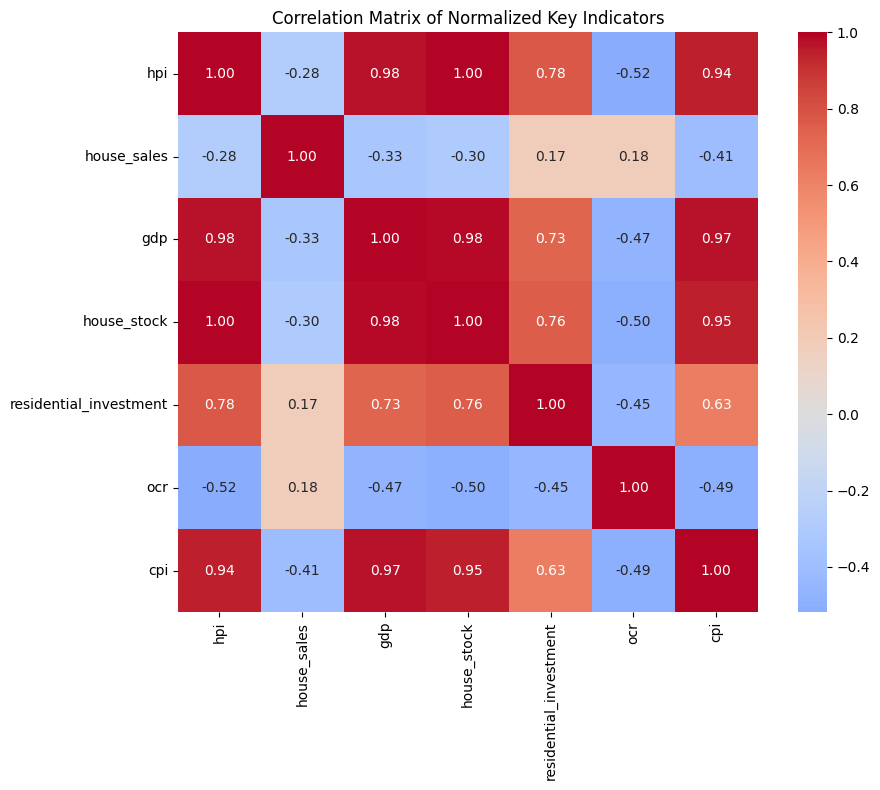

Correlations with Normalized HPI:
hpi                       1.000000
house_stock               0.998671
gdp                       0.975566
cpi                       0.942039
residential_investment    0.777780
house_sales              -0.284990
ocr                      -0.518018
Name: hpi, dtype: float64


In [4]:
df_normalized_clean = df_normalized.dropna()
corr_matrix_norm = df_normalized_clean.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_norm, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Correlation Matrix of Normalized Key Indicators')
plt.tight_layout()
plt.show()

print("Correlations with Normalized HPI:")
print(corr_matrix_norm['hpi'].sort_values(ascending=False))

# Model

In [5]:
df_model_norm = df_normalized.dropna()
features = ['house_sales', 'house_stock', 'residential_investment', 'ocr', 'cpi', 'gdp']
X_norm = df_model_norm[features]
y_norm = df_model_norm['hpi']
X_norm_const = sm.add_constant(X_norm)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm_const, y_norm, test_size=0.2, random_state=42, shuffle=False)

# Model 1: Top 3 positive correlations (house_stock, gdp, cpi)
X1 = X_norm_const[['const', 'house_stock', 'gdp', 'cpi']]
X1_train, X1_test = X_train_norm[['const', 'house_stock', 'gdp', 'cpi']], X_test_norm[['const', 'house_stock', 'gdp', 'cpi']]
ols_model1 = sm.OLS(y_train_norm, X1_train).fit()
y_pred1 = ols_model1.predict(X1_test)

# Model 2: Including next positive (residential_investment) and strongest negative (ocr)
X2 = X_norm_const[['const', 'house_stock', 'residential_investment', 'ocr']]
X2_train, X2_test = X_train_norm[['const', 'house_stock', 'residential_investment', 'ocr']], X_test_norm[['const', 'house_stock', 'residential_investment', 'ocr']]
ols_model2 = sm.OLS(y_train_norm, X2_train).fit()
y_pred2 = ols_model2.predict(X2_test)

# Model 3: Full model with all features
ols_model3 = sm.OLS(y_train_norm, X_train_norm).fit()
y_pred3 = ols_model3.predict(X_test_norm)

# Model Result

In [6]:
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse1, r2_1 = compute_metrics(y_test_norm, y_pred1)
rmse2, r2_2 = compute_metrics(y_test_norm, y_pred2)
rmse3, r2_3 = compute_metrics(y_test_norm, y_pred3)

print("Model 1 (Top 3 Positives) \n RMSE: {:.4f}, R²: {:.4f}".format(rmse1, r2_1))
print("Model 2 (house_stock + res_inv + ocr) \n RMSE: {:.4f}, R²: {:.4f}".format(rmse2, r2_2))
print("Model 3 (Full) \n RMSE: {:.4f}, R²: {:.4f}".format(rmse3, r2_3))

Model 1 (Top 3 Positives) 
 RMSE: 0.0315, R²: 0.8441
Model 2 (house_stock + res_inv + ocr) 
 RMSE: 0.0361, R²: 0.7953
Model 3 (Full) 
 RMSE: 0.0325, R²: 0.8349


# Model Comparsion

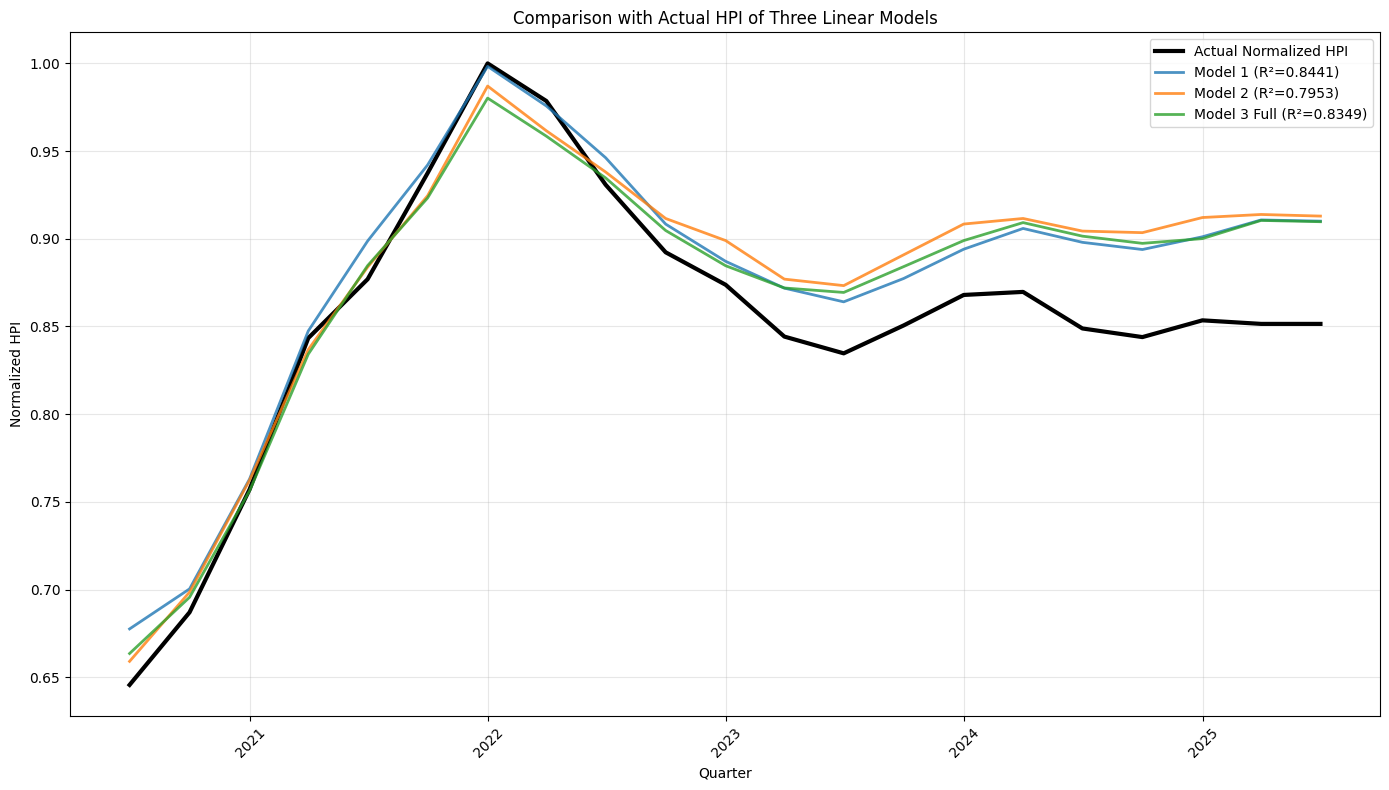

In [7]:
plt.figure(figsize=(14, 8))
test_index_norm = y_test_norm.index

plt.plot(test_index_norm, y_test_norm, label='Actual Normalized HPI', linewidth=3, color='black')
plt.plot(test_index_norm, y_pred1, label=f'Model 1 (R²={r2_1:.4f})', alpha=0.8, linewidth=2)
plt.plot(test_index_norm, y_pred2, label=f'Model 2 (R²={r2_2:.4f})', alpha=0.8, linewidth=2)
plt.plot(test_index_norm, y_pred3, label=f'Model 3 Full (R²={r2_3:.4f})', alpha=0.8, linewidth=2)

plt.title('Comparison with Actual HPI of Three Linear Models')
plt.xlabel('Quarter')
plt.ylabel('Normalized HPI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **3. Conclusion**

1.  **The relationship between features and model performance**：It is not the case that the more features there are, the better the model performs. Instead, the model with the simplest features, Model 1 (which only includes core economic indicators), performs the best, with an R² score of 0.8441. The performance of models 2 (with an R² of approximately 0.80) and 3 (with an R² of approximately 0.83) that incorporate more features actually declines. This is likely due to **multicollinearity**, where too many related features interfere with each other, thereby reducing the model's generalization ability in linear models.

2.  **The interpretability of linear relationships**：The coefficient plot of the linear model visually presents the linear relationship between each feature and the housing price index. For instance, `gdp` and `cpi` are consistently strong positive drivers, which is in line with economic common sense.

3.  **Comparison with tree-based models**：
    * Although the best-performing linear model (Model 1, with R² ≈ 0.84) achieved good results in fitting the **housing price index itself (the trend)**, it still has a significant gap compared to our previous "champion model" CatBoost (with a test set RMSE of 1.3495) when it comes to predicting **the increase in housing prices (the rate of change)**, which is a more challenging task.
    * This highlights the fundamental differences between the two model architectures: Linear models are highly adept at capturing and interpreting **long-term trends**, while Gradient Boosting Tree models (such as CatBoost) are more powerful, capable of learning and predicting the more complex non-linear relationships that drive market **short-term fluctuations and changes**.

In conclusion, the linear model provides us with a clear benchmark and good interpretability for understanding the fundamental impact of various economic indicators, and reveals the feature selection principle of "less is more" in this scenario. However, in the more challenging core task of predicting the quarterly increase in the market, the superiority of non-linear models such as CatBoost has been further demonstrated.